In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [48]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.2).tolist()

tensor([8, 7, 6, 2, 3, 5, 4, 9])
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [12]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

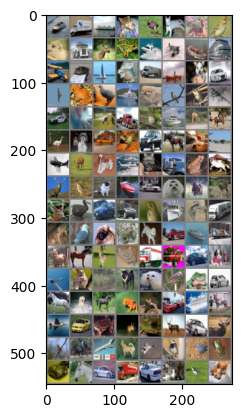

ship  truck ship  cat   bird  cat   deer  bird  cat   truck deer  frog  ship  plane ship  ship  plane cat   ship  cat   truck ship  dog   car   bird  frog  bird  ship  dog   bird  frog  plane car   cat   deer  truck bird  ship  deer  horse bird  dog   car   frog  car   horse dog   plane plane deer  dog   plane cat   truck frog  horse deer  bird  dog   ship  car   dog   deer  deer  deer  bird  car   car   bird  ship  bird  truck frog  bird  dog   frog  dog   truck ship  truck horse horse deer  cat   truck truck car   dog   plane bird  deer  dog   dog   bird  frog  car   horse dog   horse frog  cat   truck ship  horse plane car   frog  deer  frog  deer  car   deer  bird  horse plane dog   plane bird  bird  frog  car   horse car   truck car   cat   bird  cat  


In [13]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [14]:
from resnet import ResNet

In [15]:
net = ResNet()
net = net.to(device)

In [16]:
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
lossi = []
testi = []

In [18]:
def estimate_loss(split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    return loss / len(loader)

In [19]:
epochs = 32

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        lossi.append(loss.item())
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'[{epoch}, {i}] loss: {loss.item()}')

    test_loss = estimate_loss("test")
    print(f'[{epoch}] test loss: {test_loss}')
    testi.append(test_loss)


[0, 0] loss: 2.3610353469848633
[0, 200] loss: 1.5301004648208618
[0] test loss: 1.307372423666942
[1, 0] loss: 1.405814290046692
[1, 200] loss: 1.1408096551895142
[1] test loss: 1.0849669636050356
[2, 0] loss: 1.2162439823150635
[2, 200] loss: 1.1398115158081055
[2] test loss: 0.9516092206858382
[3, 0] loss: 0.8491747975349426
[3, 200] loss: 1.0301789045333862
[3] test loss: 0.8936589669577683
[4, 0] loss: 0.8569726943969727
[4, 200] loss: 0.7629501223564148
[4] test loss: 0.8083309297320209
[5, 0] loss: 0.7291882634162903
[5, 200] loss: 0.7932147979736328
[5] test loss: 0.7484072107302991
[6, 0] loss: 0.4802068769931793
[6, 200] loss: 0.589669406414032
[6] test loss: 0.721740296747111
[7, 0] loss: 0.664707601070404
[7, 200] loss: 0.5763171315193176
[7] test loss: 0.6885705763780618
[8, 0] loss: 0.6220362186431885
[8, 200] loss: 0.5979965329170227
[8] test loss: 0.6522133791748481
[9, 0] loss: 0.5890604853630066
[9, 200] loss: 0.5272926092147827
[9] test loss: 0.6273173878464517
[10, 

In [51]:
def check_accuracy(split="test"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    net.train()
    print(f'{split} accuracy: {correct / total}')
    return correct / total

check_accuracy("test")
check_accuracy("train")

test accuracy: 0.8179
train accuracy: 0.84574


0.84574

tensor([ 2426, 25182, 42048,  ..., 33096, 46815,  6950])


In [21]:
import matplotlib.pyplot as plt

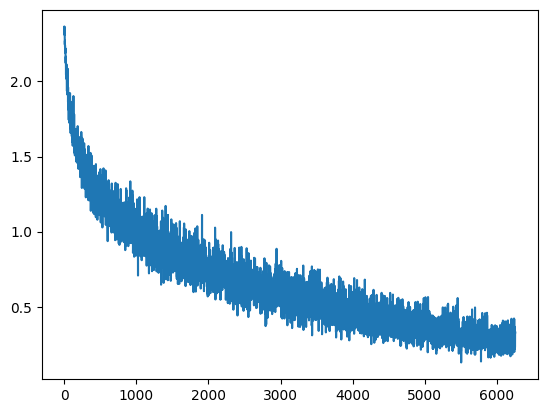

In [22]:
plt.plot(lossi)

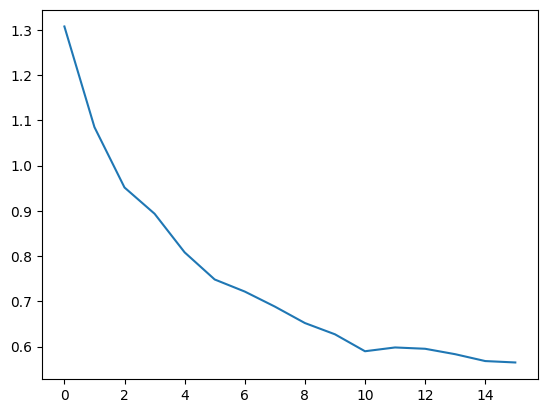

In [23]:
plt.plot(testi)